# VGG-16 Implementation  
  
    
      
      
  
This Model replicates the model described in the [**VGG-16 paper.**](https://arxiv.org/pdf/1409.1556.pdf)  
  
  VGG-16 paper is based on the VGG's **ImageNet Challenge 2014 submission**, where their team secured the first and the second places in the localisation and classification tracks respectively.  
  It's main contribution is a thorough evaluation of **networks of increasing depth** using an architecture with very small (3 × 3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16–19 weight layers.
  
However, the dataset used in our implementation is different, in which every image is of size **64 x 64 x 3**, so the first 3 stages of Convolution layers and 2 fully connected layers are implemented beacause of the small size of images.  
  
The model is implemented in **Keras with tensorflow backend.**  
  
Below Cell imports the required python libraries:

In [43]:
import h5py
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydotplus
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

The dataset is stored in a **h5 file format**, so we extract the training & test data and Class labels from the h5 package.  
  
Following function extracts the data & labels and returns them.

In [44]:
def load_dataset():
    train_dataset = h5py.File('data/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('data/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

Following function converts the categorical class labels into one hot bit arrays so that deep learning algorithms can work on it.

In [45]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Description of Data  
  
The dataset contains color images of hand signs at different angles and orientations which indicate integers from 0 to 5.  
The dataset was taken from the [coursera.org](http://www.coursera.org) website.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <font color='purple'>  **SIGNS dataset** </center></caption>
Total images in Dataset:   **1200** images  
Images in Training:        **1080** images  
Images is Testing:         **120** images  
Dimensions of an Image:    **64 x 64 x 3**  
Number of classes: **6** Classes
  
  The dataset was taken from the coursera.org

The images are normalized by dividing them with 255.

In [46]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Run below cell to look at a particular image from training set...(You can change value of i for corresponding image).

class:  [2]


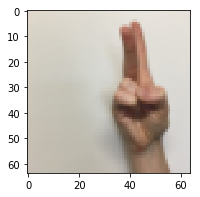

In [47]:
# Display image
i=80
print('class: ',Y_train_orig[:,i])
plt.figure(figsize=(3,3))
plt.imshow(X_train_orig[i]);

# Model Description:  

Below Model uses **7 Convolution layers**. In every covulation layer:
+ Filter size : **3 x 3**
+ **No** Padding
+ Strides : **1**
+ All the parameters are **randomly initialized** with seed=0
+ Activation function used : **Relu**
  
There are **3 MaxPool layers**,in which:
+ Filter size : **2 x 2**
+ Strides : **2**

And **2 fully connected layers**:
+ First fully connected layer has **1024 hidden units** and **Relu activation**
+ second fully connected layer has **6 hidden units** and uses **Softmax activation**
  
The comvolution and Maxpooling layers are expanded accross 3 stages:
+ First stage uses **64 filters**
+ Second stage uses **128 filters**
+ Third stage uses **256 filters**

(Originally there are 5 stages in VGG16 Network but due to image size restrictions, our model is limited to 3 stages)  
  
After 3 Convolution stages, The images are **flattened** and feeded to fully connected layers.

In [52]:
def VGG16(input_shape = (64, 64, 3), classes = 6):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2),name='max_pool1')(X)

    # Stage 2
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2),name='max_pool2')(X)

    # Stage 3 
    X = Conv2D(256, (3, 3), strides = (1, 1), name = 'conv5', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(256, (3, 3), strides = (1, 1), name = 'conv6', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(256, (3, 3), strides = (1, 1), name = 'conv7', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2),name='max_pool3')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(1024, activation='relu', name='fc1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='VGG16')

    return model

Following Cell creates the above described model.

In [53]:
model = VGG16(input_shape = (64, 64, 3), classes = 6)

After creating the model we need to compile it using a optimizer in order to minimize a particular loss function.  
   
In our model:
+ Optimizer used : **Adams Optimizer**
+ Loss function : **Categorical Cross Entropy**

Run following cell to compile the model.

In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Now our model is ready to be trained on the traing set, Here we used:
+ No. of iterations: **5**
+ Size of mini batches: **16**  

Run the following cell to train the model on 5 iterations with a batch size of 16. 

In [55]:
model.fit(X_train, Y_train, epochs = 5, batch_size = 32)

Epoch 1/5
1080/1080 [==============================] - 174s 161ms/step - loss: 13.1409 - acc: 0.1639
Epoch 2/5
1080/1080 [==============================] - 162s 150ms/step - loss: 13.4317 - acc: 0.1667
Epoch 3/5
1080/1080 [==============================] - 168s 155ms/step - loss: 13.4317 - acc: 0.1667
Epoch 4/5
1080/1080 [==============================] - 174s 161ms/step - loss: 13.4317 - acc: 0.1667
Epoch 5/5
1080/1080 [==============================] - 177s 164ms/step - loss: 13.4317 - acc: 0.1667


Let's see how this model (trained on only five iterations) performs on the test set.

In [56]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 6s 50ms/step
Loss = 13.4317464828
Test Accuracy = 0.166666667163


Here is a **summary** of the above model.    
  
  
It shows the **dimensions of output** at every layer and the **no. of parameters** at every layer.  
  
  Total trainable Parameters in the model: **5,936,966**

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 68, 68, 64)        1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 66, 66, 64)        36928     
_________________________________________________________________
activation_19 (Activation)   (None, 66, 66, 64)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 33, 33, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 31, 31, 128)       73856     
__________